데이터셋에 레이블이 지정됐을 경우에는 지도 학습이, 데이터셋에 레이블이 없는 경우에는 비지도학습이 필요하다. 현실 세계에서는 레이블이 있는 경우와 없는 경우가 명확히 구분되지 않는다. 일반적으로 데이터셋은 레이블이 부분적으로 존재한다. 그리고 레이블이 있는 셋의 정보를 활용해 레이블이 없는 과늑치에 효율적으로 레이블을 정의할 수 있다. 지도 학습 문제에서는 레이블이 없는 데이터셋은 대부분 버려야한다. 반면, 비지도 학습 문제에서는 데이터 대부분을 사용할 수 잇지만 일부에 존재하는 레이블을 활용하는 방법을 모른다.

준지도 학습(semisupervised learning)은 지도 학습과 비지도 학습의 장점을 모두 가진다. 레이블이 약간만 있어도 데이터셋의 구조를 파악하고 레이블이 지정되지 않은 관측치에 레이블을 지정할 수 있다.

지금까지 우리는 지도 학습과 비지도 학습을 둘로 분리된 머신러닝 분야로 봤다. 데이터셋에 레이블이 지정됐을 경우에는 지도 학습이 , 데이터셋에 레이블이 없는 경우에는 비지도 학습이 필요하다.


In [2]:
import numpy as np
import pandas as pd 
import os, time,re
import pickle ,gzip

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

color =sns.color_palette()
%matplotlib inline

from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.metrics import log_loss, precision_recall_curve, average_precision_score, roc_curve, auc, roc_auc_score

import lightgbm as lgb


import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation ,Dense, Dropout
from tensorflow.keras.layers import BatchNormalization , Input , Lambda
from tensorflow.keras import regularizers
from tensorflow.keras.losses import mse, binary_crossentropy










이전에 한 것처럼, 훈련 및 테스트셋을 생성한다. 그러나 일부 레이블이 있는 데이터셋을 어떻게 활용하는지 시뮬레이션하기 위해 사기 거래의 90%를 훈련셋에서 제외한다.

이는 매우 위험한 발상처러 보일 수 있다. 하지만 실제 지불 사기와 관련된 현실 세계의 문제에서도 사기 발생률은 이와 유사하게 매우 낮다( 사기 거래는 10,000건당 1건에 불과). 우리는 훈련셋에서 레이블의 90%를 제거함으로써 이현상을 적용해 실습한다.



In [3]:
# 데이터 로드
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'credit_card_data', 'creditcard.csv'])
data = pd.read_csv(current_path + file)

dataX = data.copy().drop(['Class','Time'],axis=1)
dataY = data['Class'].copy()

# 데이터 스케일
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])

# 훈련 및 테스트 셋 분할
X_train, X_test, y_train, y_test = \
    train_test_split(dataX, dataY, test_size=0.33, \
                     random_state=2018, stratify=dataY)

In [4]:
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [5]:
'''
# 훈련 셋으로부터 레이블 90% 제거
'''

toDrop = y_train[y_train==1].sample(frac=0.90,random_state=2018)
X_train.drop(labels=toDrop.index,inplace=True)
y_train.drop(labels=toDrop.index,inplace=True)

C:\Users\admin\AppData\Local\conda\conda\envs\kyu3.7\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [6]:
toDrop

30496     1
43428     1
150644    1
15204     1
86155     1
         ..
254395    1
64411     1
151009    1
239501    1
147605    1
Name: Class, Length: 297, dtype: int64

In [7]:
# 평가 함수(이상치 스코어 함수) 및 그래프 함수 정의

def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - \
                   np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss


def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'], \
                               preds['anomalyScore'])
    average_precision = average_precision_score( \
                        preds['trueLabel'], preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
        {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the \
        curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, average_precision


precisionAnalysis 함수로 특정 수준의 재현율에서 모델의 정밀도를 평가. 구체적으로 테스트셋에서 신용카드 사기 거래의 75%를 탐지하는 모델의 정밀도가 어느 정도인지 판단. 정밀도가 높을수록 더 좋은 모델이다.


이는 합리적인 기준임. 다시 말해, 사기 거래의 75%를 가능한 한 높은 정밀도로 탐지하고자 한다. 충분히 높은 정밀도를 달성하지 못하면 신용카드 정상 거래를 불필요하게 거절할 것이고, 이로 인해 고객 관계가 악화될 수 있음.


In [8]:
def precisionAnalysis(df, column, threshold):
    df.sort_values(by=column, ascending=False, inplace=True)
    threshold_value = threshold*df.trueLabel.sum()
    i = 0
    j = 0
    while i < threshold_value+1:
        if df.iloc[j]["trueLabel"]==1:
            i += 1
        j += 1
    return df, i/j


# 9.2 지도 학습 모델

준지도 학습 모델을 벤치마킹하기 위해 먼저 지도 학습 모델과 비지도 학습 모델이 개별적으로 얼마나 잘 작동하는지 확인.



In [18]:
k_fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2018)

params_lightGB = {
    'task': 'train',
    'application':'binary',
    'num_class':1,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbose': 0,
    'num_threads':16
}

In [19]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[], index=y_train.index, \
                                        columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), \
                                          y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
        X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, gbm.predict(X_train_fold, \
                                num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = \
        gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, \
        predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLightGBMGradientBoosting = log_loss(y_train, \
        predictionsBasedOnKFolds.loc[:,'prediction'])
print('LightGBM Gradient Boosting Log Loss: ', \
        loglossLightGBMGradientBoosting)

[1]	valid_0's binary_logloss: 0.00328814
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.00501798
[3]	valid_0's binary_logloss: 0.0113596
[4]	valid_0's binary_logloss: 0.0134411
[5]	valid_0's binary_logloss: 0.0120885
[6]	valid_0's binary_logloss: 0.0118795
[7]	valid_0's binary_logloss: 0.0123715
[8]	valid_0's binary_logloss: 0.0112126
[9]	valid_0's binary_logloss: 0.0111943
[10]	valid_0's binary_logloss: 0.0110223
[11]	valid_0's binary_logloss: 0.0119001
[12]	valid_0's binary_logloss: 0.011144
[13]	valid_0's binary_logloss: 0.0108834
[14]	valid_0's binary_logloss: 0.0103315
[15]	valid_0's binary_logloss: 0.010241
[16]	valid_0's binary_logloss: 0.0102127
[17]	valid_0's binary_logloss: 0.0101784
[18]	valid_0's binary_logloss: 0.0101528
[19]	valid_0's binary_logloss: 0.0103359
[20]	valid_0's binary_logloss: 0.0103066
[21]	valid_0's binary_logloss: 0.010272
[22]	valid_0's binary_logloss: 0.0102553
[23]	valid_0's binary_logloss: 0.0102284
[24]	

[195]	valid_0's binary_logloss: 0.00939803
[196]	valid_0's binary_logloss: 0.0093973
[197]	valid_0's binary_logloss: 0.00939095
[198]	valid_0's binary_logloss: 0.00938776
[199]	valid_0's binary_logloss: 0.00938722
[200]	valid_0's binary_logloss: 0.00938129
[201]	valid_0's binary_logloss: 0.00938015
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.00328814
Training Log Loss:  0.002931231218128015
CV Log Loss:  0.0032881388005420696
[1]	valid_0's binary_logloss: 0.002832
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.00159326
[3]	valid_0's binary_logloss: 0.00109952
[4]	valid_0's binary_logloss: 0.00128771
[5]	valid_0's binary_logloss: 0.00128578
[6]	valid_0's binary_logloss: 0.00128359
[7]	valid_0's binary_logloss: 0.00128148
[8]	valid_0's binary_logloss: 0.00127937
[9]	valid_0's binary_logloss: 0.00127729
[10]	valid_0's binary_logloss: 0.00127519
[11]	valid_0's binary_logloss: 0.00127372
[12]	valid_0's binary_logloss: 0.0

[192]	valid_0's binary_logloss: 0.00100887
[193]	valid_0's binary_logloss: 0.0010077
[194]	valid_0's binary_logloss: 0.00100725
[195]	valid_0's binary_logloss: 0.00100681
[196]	valid_0's binary_logloss: 0.00100565
[197]	valid_0's binary_logloss: 0.00100522
[198]	valid_0's binary_logloss: 0.00100407
[199]	valid_0's binary_logloss: 0.00100361
[200]	valid_0's binary_logloss: 0.00100318
[201]	valid_0's binary_logloss: 0.00100205
[202]	valid_0's binary_logloss: 0.0010016
[203]	valid_0's binary_logloss: 0.00100119
[204]	valid_0's binary_logloss: 0.00100042
[205]	valid_0's binary_logloss: 0.000999982
[206]	valid_0's binary_logloss: 0.000998871
[207]	valid_0's binary_logloss: 0.000998476
[208]	valid_0's binary_logloss: 0.000998051
[209]	valid_0's binary_logloss: 0.00099753
[210]	valid_0's binary_logloss: 0.000996436
[211]	valid_0's binary_logloss: 0.000995925
[212]	valid_0's binary_logloss: 0.000994841
[213]	valid_0's binary_logloss: 0.000994433
[214]	valid_0's binary_logloss: 0.000993932
[215

[378]	valid_0's binary_logloss: 0.00090207
[379]	valid_0's binary_logloss: 0.000901852
[380]	valid_0's binary_logloss: 0.000901386
[381]	valid_0's binary_logloss: 0.000901238
[382]	valid_0's binary_logloss: 0.000900756
[383]	valid_0's binary_logloss: 0.000899956
[384]	valid_0's binary_logloss: 0.000899804
[385]	valid_0's binary_logloss: 0.000900041
[386]	valid_0's binary_logloss: 0.000898893
[387]	valid_0's binary_logloss: 0.000898098
[388]	valid_0's binary_logloss: 0.000897621
[389]	valid_0's binary_logloss: 0.000897861
[390]	valid_0's binary_logloss: 0.000896708
[391]	valid_0's binary_logloss: 0.000896253
[392]	valid_0's binary_logloss: 0.000895111
[393]	valid_0's binary_logloss: 0.000894657
[394]	valid_0's binary_logloss: 0.000893522
[395]	valid_0's binary_logloss: 0.000892379
[396]	valid_0's binary_logloss: 0.000891597
[397]	valid_0's binary_logloss: 0.000890458
[398]	valid_0's binary_logloss: 0.000890009
[399]	valid_0's binary_logloss: 0.000888882
[400]	valid_0's binary_logloss: 0

[575]	valid_0's binary_logloss: 0.00082175
[576]	valid_0's binary_logloss: 0.000820966
[577]	valid_0's binary_logloss: 0.000820962
[578]	valid_0's binary_logloss: 0.000820876
[579]	valid_0's binary_logloss: 0.000820583
[580]	valid_0's binary_logloss: 0.000819802
[581]	valid_0's binary_logloss: 0.000819722
[582]	valid_0's binary_logloss: 0.000818943
[583]	valid_0's binary_logloss: 0.000818599
[584]	valid_0's binary_logloss: 0.000818308
[585]	valid_0's binary_logloss: 0.00081753
[586]	valid_0's binary_logloss: 0.000817185
[587]	valid_0's binary_logloss: 0.000817182
[588]	valid_0's binary_logloss: 0.000816893
[589]	valid_0's binary_logloss: 0.000816118
[590]	valid_0's binary_logloss: 0.000816029
[591]	valid_0's binary_logloss: 0.000815816
[592]	valid_0's binary_logloss: 0.000815043
[593]	valid_0's binary_logloss: 0.000814273
[594]	valid_0's binary_logloss: 0.000814181
[595]	valid_0's binary_logloss: 0.000813969
[596]	valid_0's binary_logloss: 0.0008132
[597]	valid_0's binary_logloss: 0.00

[771]	valid_0's binary_logloss: 0.000776048
[772]	valid_0's binary_logloss: 0.000775036
[773]	valid_0's binary_logloss: 0.00077513
[774]	valid_0's binary_logloss: 0.000774125
[775]	valid_0's binary_logloss: 0.000773117
[776]	valid_0's binary_logloss: 0.000772605
[777]	valid_0's binary_logloss: 0.000772432
[778]	valid_0's binary_logloss: 0.000772292
[779]	valid_0's binary_logloss: 0.000771735
[780]	valid_0's binary_logloss: 0.000771564
[781]	valid_0's binary_logloss: 0.000771058
[782]	valid_0's binary_logloss: 0.000770059
[783]	valid_0's binary_logloss: 0.000770149
[784]	valid_0's binary_logloss: 0.000769981
[785]	valid_0's binary_logloss: 0.000769477
[786]	valid_0's binary_logloss: 0.000768926
[787]	valid_0's binary_logloss: 0.000768791
[788]	valid_0's binary_logloss: 0.000768808
[789]	valid_0's binary_logloss: 0.000768822
[790]	valid_0's binary_logloss: 0.000768319
[791]	valid_0's binary_logloss: 0.000768186
[792]	valid_0's binary_logloss: 0.000768024
[793]	valid_0's binary_logloss: 0

[964]	valid_0's binary_logloss: 0.000747408
[965]	valid_0's binary_logloss: 0.000746882
[966]	valid_0's binary_logloss: 0.000747251
[967]	valid_0's binary_logloss: 0.000746879
[968]	valid_0's binary_logloss: 0.000746776
[969]	valid_0's binary_logloss: 0.000746322
[970]	valid_0's binary_logloss: 0.000746244
[971]	valid_0's binary_logloss: 0.000746142
[972]	valid_0's binary_logloss: 0.000745609
[973]	valid_0's binary_logloss: 0.000745533
[974]	valid_0's binary_logloss: 0.000745067
[975]	valid_0's binary_logloss: 0.000745355
[976]	valid_0's binary_logloss: 0.00074498
[977]	valid_0's binary_logloss: 0.000745255
[978]	valid_0's binary_logloss: 0.000744782
[979]	valid_0's binary_logloss: 0.000745076
[980]	valid_0's binary_logloss: 0.000744626
[981]	valid_0's binary_logloss: 0.000744252
[982]	valid_0's binary_logloss: 0.000744632
[983]	valid_0's binary_logloss: 0.000743754
[984]	valid_0's binary_logloss: 0.000743307
[985]	valid_0's binary_logloss: 0.000742946
[986]	valid_0's binary_logloss: 0

[1157]	valid_0's binary_logloss: 0.000716769
[1158]	valid_0's binary_logloss: 0.000716399
[1159]	valid_0's binary_logloss: 0.00071621
[1160]	valid_0's binary_logloss: 0.000716007
[1161]	valid_0's binary_logloss: 0.000716062
[1162]	valid_0's binary_logloss: 0.000716149
[1163]	valid_0's binary_logloss: 0.00071592
[1164]	valid_0's binary_logloss: 0.000715449
[1165]	valid_0's binary_logloss: 0.000715081
[1166]	valid_0's binary_logloss: 0.000715299
[1167]	valid_0's binary_logloss: 0.000714531
[1168]	valid_0's binary_logloss: 0.000714186
[1169]	valid_0's binary_logloss: 0.00071342
[1170]	valid_0's binary_logloss: 0.000713475
[1171]	valid_0's binary_logloss: 0.000713564
[1172]	valid_0's binary_logloss: 0.000713654
[1173]	valid_0's binary_logloss: 0.000713186
[1174]	valid_0's binary_logloss: 0.000713277
[1175]	valid_0's binary_logloss: 0.000713367
[1176]	valid_0's binary_logloss: 0.000713645
[1177]	valid_0's binary_logloss: 0.000713737
[1178]	valid_0's binary_logloss: 0.000713558
[1179]	valid_

[1346]	valid_0's binary_logloss: 0.000722455
[1347]	valid_0's binary_logloss: 0.000722482
[1348]	valid_0's binary_logloss: 0.000722441
[1349]	valid_0's binary_logloss: 0.00072241
[1350]	valid_0's binary_logloss: 0.000722369
[1351]	valid_0's binary_logloss: 0.000722671
[1352]	valid_0's binary_logloss: 0.000722921
[1353]	valid_0's binary_logloss: 0.000722991
[1354]	valid_0's binary_logloss: 0.00072284
[1355]	valid_0's binary_logloss: 0.00072281
[1356]	valid_0's binary_logloss: 0.000723035
[1357]	valid_0's binary_logloss: 0.000723072
[1358]	valid_0's binary_logloss: 0.000723463
[1359]	valid_0's binary_logloss: 0.000723503
[1360]	valid_0's binary_logloss: 0.000723679
[1361]	valid_0's binary_logloss: 0.000723334
[1362]	valid_0's binary_logloss: 0.000723059
[1363]	valid_0's binary_logloss: 0.000723373
[1364]	valid_0's binary_logloss: 0.00072276
[1365]	valid_0's binary_logloss: 0.000722774
[1366]	valid_0's binary_logloss: 0.000722973
[1367]	valid_0's binary_logloss: 0.000723172
[1368]	valid_0

[1535]	valid_0's binary_logloss: 0.000696691
[1536]	valid_0's binary_logloss: 0.000696671
[1537]	valid_0's binary_logloss: 0.000696989
[1538]	valid_0's binary_logloss: 0.000697056
[1539]	valid_0's binary_logloss: 0.000697031
[1540]	valid_0's binary_logloss: 0.000697092
[1541]	valid_0's binary_logloss: 0.000697068
[1542]	valid_0's binary_logloss: 0.000697134
[1543]	valid_0's binary_logloss: 0.000697041
[1544]	valid_0's binary_logloss: 0.000697018
[1545]	valid_0's binary_logloss: 0.000696774
[1546]	valid_0's binary_logloss: 0.000696765
[1547]	valid_0's binary_logloss: 0.000696744
[1548]	valid_0's binary_logloss: 0.00069681
[1549]	valid_0's binary_logloss: 0.000696866
[1550]	valid_0's binary_logloss: 0.000696844
[1551]	valid_0's binary_logloss: 0.000696748
[1552]	valid_0's binary_logloss: 0.00069664
[1553]	valid_0's binary_logloss: 0.000696619
[1554]	valid_0's binary_logloss: 0.00069661
[1555]	valid_0's binary_logloss: 0.000696588
[1556]	valid_0's binary_logloss: 0.000696712
[1557]	valid_

[1719]	valid_0's binary_logloss: 0.000692819
[1720]	valid_0's binary_logloss: 0.000692659
[1721]	valid_0's binary_logloss: 0.000692661
[1722]	valid_0's binary_logloss: 0.000692696
[1723]	valid_0's binary_logloss: 0.000692726
[1724]	valid_0's binary_logloss: 0.000692763
[1725]	valid_0's binary_logloss: 0.000692951
[1726]	valid_0's binary_logloss: 0.000692644
[1727]	valid_0's binary_logloss: 0.000692483
[1728]	valid_0's binary_logloss: 0.000692485
[1729]	valid_0's binary_logloss: 0.00069252
[1730]	valid_0's binary_logloss: 0.000692551
[1731]	valid_0's binary_logloss: 0.000692588
[1732]	valid_0's binary_logloss: 0.000692539
[1733]	valid_0's binary_logloss: 0.000692384
[1734]	valid_0's binary_logloss: 0.000692223
[1735]	valid_0's binary_logloss: 0.000692257
[1736]	valid_0's binary_logloss: 0.000692287
[1737]	valid_0's binary_logloss: 0.00069198
[1738]	valid_0's binary_logloss: 0.000692017
[1739]	valid_0's binary_logloss: 0.000692224
[1740]	valid_0's binary_logloss: 0.000692227
[1741]	valid

[1907]	valid_0's binary_logloss: 0.000691697
[1908]	valid_0's binary_logloss: 0.000691866
[1909]	valid_0's binary_logloss: 0.000691984
[1910]	valid_0's binary_logloss: 0.000692018
[1911]	valid_0's binary_logloss: 0.000692152
[1912]	valid_0's binary_logloss: 0.000691996
[1913]	valid_0's binary_logloss: 0.000691776
[1914]	valid_0's binary_logloss: 0.000691523
[1915]	valid_0's binary_logloss: 0.000691275
[1916]	valid_0's binary_logloss: 0.000691409
[1917]	valid_0's binary_logloss: 0.000691442
[1918]	valid_0's binary_logloss: 0.00069146
[1919]	valid_0's binary_logloss: 0.000691242
[1920]	valid_0's binary_logloss: 0.000691322
[1921]	valid_0's binary_logloss: 0.000691439
[1922]	valid_0's binary_logloss: 0.000691472
[1923]	valid_0's binary_logloss: 0.00069123
[1924]	valid_0's binary_logloss: 0.000691362
[1925]	valid_0's binary_logloss: 0.000691121
[1926]	valid_0's binary_logloss: 0.000691278
[1927]	valid_0's binary_logloss: 0.000691296
[1928]	valid_0's binary_logloss: 0.000691412
[1929]	valid

[95]	valid_0's binary_logloss: 0.00318096
[96]	valid_0's binary_logloss: 0.00317929
[97]	valid_0's binary_logloss: 0.003178
[98]	valid_0's binary_logloss: 0.00317644
[99]	valid_0's binary_logloss: 0.00317488
[100]	valid_0's binary_logloss: 0.00317335
[101]	valid_0's binary_logloss: 0.00317184
[102]	valid_0's binary_logloss: 0.00317071
[103]	valid_0's binary_logloss: 0.0031699
[104]	valid_0's binary_logloss: 0.00316908
[105]	valid_0's binary_logloss: 0.0031683
[106]	valid_0's binary_logloss: 0.00316758
[107]	valid_0's binary_logloss: 0.00316685
[108]	valid_0's binary_logloss: 0.00316607
[109]	valid_0's binary_logloss: 0.00316529
[110]	valid_0's binary_logloss: 0.00316451
[111]	valid_0's binary_logloss: 0.00316374
[112]	valid_0's binary_logloss: 0.003163
[113]	valid_0's binary_logloss: 0.00316224
[114]	valid_0's binary_logloss: 0.003158
[115]	valid_0's binary_logloss: 0.00315728
[116]	valid_0's binary_logloss: 0.00315657
[117]	valid_0's binary_logloss: 0.00315587
[118]	valid_0's binary_l

[297]	valid_0's binary_logloss: 0.00306462
[298]	valid_0's binary_logloss: 0.00306472
[299]	valid_0's binary_logloss: 0.0030646
[300]	valid_0's binary_logloss: 0.00306472
[301]	valid_0's binary_logloss: 0.0030639
[302]	valid_0's binary_logloss: 0.00306379
[303]	valid_0's binary_logloss: 0.00306391
[304]	valid_0's binary_logloss: 0.00306403
[305]	valid_0's binary_logloss: 0.00306414
[306]	valid_0's binary_logloss: 0.00306426
[307]	valid_0's binary_logloss: 0.00306417
[308]	valid_0's binary_logloss: 0.00306408
[309]	valid_0's binary_logloss: 0.0030633
[310]	valid_0's binary_logloss: 0.00306343
[311]	valid_0's binary_logloss: 0.00306356
[312]	valid_0's binary_logloss: 0.00306346
[313]	valid_0's binary_logloss: 0.0030636
[314]	valid_0's binary_logloss: 0.00306373
[315]	valid_0's binary_logloss: 0.00306386
[316]	valid_0's binary_logloss: 0.00306379
[317]	valid_0's binary_logloss: 0.00306393
[318]	valid_0's binary_logloss: 0.00306299
[319]	valid_0's binary_logloss: 0.00306313
[320]	valid_0's

[496]	valid_0's binary_logloss: 0.00309317
[497]	valid_0's binary_logloss: 0.00309342
[498]	valid_0's binary_logloss: 0.00309397
[499]	valid_0's binary_logloss: 0.0030942
[500]	valid_0's binary_logloss: 0.00309445
[501]	valid_0's binary_logloss: 0.00309536
[502]	valid_0's binary_logloss: 0.00309562
[503]	valid_0's binary_logloss: 0.00309551
[504]	valid_0's binary_logloss: 0.0030961
[505]	valid_0's binary_logloss: 0.00309633
[506]	valid_0's binary_logloss: 0.0030966
[507]	valid_0's binary_logloss: 0.00309674
[508]	valid_0's binary_logloss: 0.00309702
[509]	valid_0's binary_logloss: 0.00309759
[510]	valid_0's binary_logloss: 0.00309819
[511]	valid_0's binary_logloss: 0.00309847
[512]	valid_0's binary_logloss: 0.00309903
[513]	valid_0's binary_logloss: 0.00309931
[514]	valid_0's binary_logloss: 0.00309957
[515]	valid_0's binary_logloss: 0.00309987
[516]	valid_0's binary_logloss: 0.00310047
[517]	valid_0's binary_logloss: 0.00310105
[518]	valid_0's binary_logloss: 0.00310135
[519]	valid_0'

[152]	valid_0's binary_logloss: 0.00236282
[153]	valid_0's binary_logloss: 0.00236178
[154]	valid_0's binary_logloss: 0.00236076
[155]	valid_0's binary_logloss: 0.00235898
[156]	valid_0's binary_logloss: 0.00235722
[157]	valid_0's binary_logloss: 0.00235583
[158]	valid_0's binary_logloss: 0.00235409
[159]	valid_0's binary_logloss: 0.00235272
[160]	valid_0's binary_logloss: 0.002351
[161]	valid_0's binary_logloss: 0.00234965
[162]	valid_0's binary_logloss: 0.00234796
[163]	valid_0's binary_logloss: 0.00234662
[164]	valid_0's binary_logloss: 0.00234494
[165]	valid_0's binary_logloss: 0.00234363
[166]	valid_0's binary_logloss: 0.00234197
[167]	valid_0's binary_logloss: 0.00234032
[168]	valid_0's binary_logloss: 0.00233904
[169]	valid_0's binary_logloss: 0.0023374
[170]	valid_0's binary_logloss: 0.00233614
[171]	valid_0's binary_logloss: 0.00233452
[172]	valid_0's binary_logloss: 0.00233328
[173]	valid_0's binary_logloss: 0.00233168
[174]	valid_0's binary_logloss: 0.00233045
[175]	valid_0'

[352]	valid_0's binary_logloss: 0.00219126
[353]	valid_0's binary_logloss: 0.00219084
[354]	valid_0's binary_logloss: 0.00219067
[355]	valid_0's binary_logloss: 0.00219025
[356]	valid_0's binary_logloss: 0.00219026
[357]	valid_0's binary_logloss: 0.0021901
[358]	valid_0's binary_logloss: 0.00218969
[359]	valid_0's binary_logloss: 0.00218952
[360]	valid_0's binary_logloss: 0.00218936
[361]	valid_0's binary_logloss: 0.00218937
[362]	valid_0's binary_logloss: 0.00218921
[363]	valid_0's binary_logloss: 0.00218905
[364]	valid_0's binary_logloss: 0.00218889
[365]	valid_0's binary_logloss: 0.00218873
[366]	valid_0's binary_logloss: 0.00218875
[367]	valid_0's binary_logloss: 0.0021886
[368]	valid_0's binary_logloss: 0.00218844
[369]	valid_0's binary_logloss: 0.00218829
[370]	valid_0's binary_logloss: 0.00218814
[371]	valid_0's binary_logloss: 0.00218799
[372]	valid_0's binary_logloss: 0.00218784
[373]	valid_0's binary_logloss: 0.00218769
[374]	valid_0's binary_logloss: 0.00218771
[375]	valid_0

[550]	valid_0's binary_logloss: 0.00217864
[551]	valid_0's binary_logloss: 0.00217842
[552]	valid_0's binary_logloss: 0.00217829
[553]	valid_0's binary_logloss: 0.00217807
[554]	valid_0's binary_logloss: 0.00217794
[555]	valid_0's binary_logloss: 0.00217772
[556]	valid_0's binary_logloss: 0.00217721
[557]	valid_0's binary_logloss: 0.00217708
[558]	valid_0's binary_logloss: 0.00217695
[559]	valid_0's binary_logloss: 0.00217688
[560]	valid_0's binary_logloss: 0.00217676
[561]	valid_0's binary_logloss: 0.00217653
[562]	valid_0's binary_logloss: 0.00217643
[563]	valid_0's binary_logloss: 0.00217621
[564]	valid_0's binary_logloss: 0.0021757
[565]	valid_0's binary_logloss: 0.00217558
[566]	valid_0's binary_logloss: 0.00217545
[567]	valid_0's binary_logloss: 0.00217539
[568]	valid_0's binary_logloss: 0.00217526
[569]	valid_0's binary_logloss: 0.00217504
[570]	valid_0's binary_logloss: 0.00217495
[571]	valid_0's binary_logloss: 0.00217474
[572]	valid_0's binary_logloss: 0.00217525
[573]	valid_

[750]	valid_0's binary_logloss: 0.00215885
[751]	valid_0's binary_logloss: 0.00215867
[752]	valid_0's binary_logloss: 0.00215873
[753]	valid_0's binary_logloss: 0.00215886
[754]	valid_0's binary_logloss: 0.00215866
[755]	valid_0's binary_logloss: 0.00215849
[756]	valid_0's binary_logloss: 0.00215854
[757]	valid_0's binary_logloss: 0.00215835
[758]	valid_0's binary_logloss: 0.00215841
[759]	valid_0's binary_logloss: 0.00215854
[760]	valid_0's binary_logloss: 0.00215837
[761]	valid_0's binary_logloss: 0.00215818
[762]	valid_0's binary_logloss: 0.00215823
[763]	valid_0's binary_logloss: 0.00215875
[764]	valid_0's binary_logloss: 0.00215858
[765]	valid_0's binary_logloss: 0.00215839
[766]	valid_0's binary_logloss: 0.00215845
[767]	valid_0's binary_logloss: 0.00215828
[768]	valid_0's binary_logloss: 0.0021581
[769]	valid_0's binary_logloss: 0.00215815
[770]	valid_0's binary_logloss: 0.00215867
[771]	valid_0's binary_logloss: 0.00215859
[772]	valid_0's binary_logloss: 0.00215841
[773]	valid_

[947]	valid_0's binary_logloss: 0.0021528
[948]	valid_0's binary_logloss: 0.0021527
[949]	valid_0's binary_logloss: 0.00215274
[950]	valid_0's binary_logloss: 0.00215324
[951]	valid_0's binary_logloss: 0.00215321
[952]	valid_0's binary_logloss: 0.0021531
[953]	valid_0's binary_logloss: 0.00215317
[954]	valid_0's binary_logloss: 0.00215308
[955]	valid_0's binary_logloss: 0.00215327
[956]	valid_0's binary_logloss: 0.00215316
[957]	valid_0's binary_logloss: 0.00215366
[958]	valid_0's binary_logloss: 0.00215371
[959]	valid_0's binary_logloss: 0.00215367
[960]	valid_0's binary_logloss: 0.00215417
[961]	valid_0's binary_logloss: 0.00215407
[962]	valid_0's binary_logloss: 0.00215411
[963]	valid_0's binary_logloss: 0.00215401
[964]	valid_0's binary_logloss: 0.00215391
[965]	valid_0's binary_logloss: 0.00215398
[966]	valid_0's binary_logloss: 0.00215395
[967]	valid_0's binary_logloss: 0.00215392
[968]	valid_0's binary_logloss: 0.00215396
[969]	valid_0's binary_logloss: 0.00215386
[970]	valid_0'

[63]	valid_0's binary_logloss: 0.00425056
[64]	valid_0's binary_logloss: 0.00424068
[65]	valid_0's binary_logloss: 0.00423104
[66]	valid_0's binary_logloss: 0.00422154
[67]	valid_0's binary_logloss: 0.00421263
[68]	valid_0's binary_logloss: 0.00420536
[69]	valid_0's binary_logloss: 0.00419643
[70]	valid_0's binary_logloss: 0.00418785
[71]	valid_0's binary_logloss: 0.00417825
[72]	valid_0's binary_logloss: 0.00416934
[73]	valid_0's binary_logloss: 0.00416132
[74]	valid_0's binary_logloss: 0.00417267
[75]	valid_0's binary_logloss: 0.00418497
[76]	valid_0's binary_logloss: 0.00419049
[77]	valid_0's binary_logloss: 0.00418655
[78]	valid_0's binary_logloss: 0.00418695
[79]	valid_0's binary_logloss: 0.00418369
[80]	valid_0's binary_logloss: 0.00417931
[81]	valid_0's binary_logloss: 0.00417197
[82]	valid_0's binary_logloss: 0.00416819
[83]	valid_0's binary_logloss: 0.00416621
[84]	valid_0's binary_logloss: 0.00416201
[85]	valid_0's binary_logloss: 0.00415575
[86]	valid_0's binary_logloss: 0.0

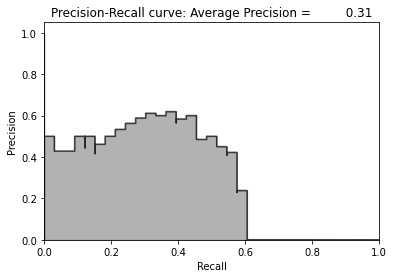

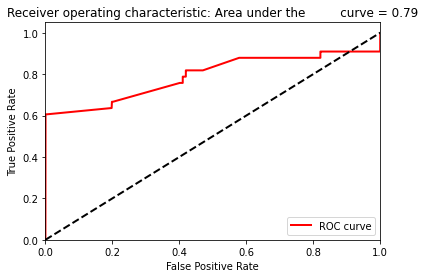

In [21]:
preds, average_precision = plotResults(y_train, \
                        predictionsBasedOnKFolds.loc[:,'prediction'], True)

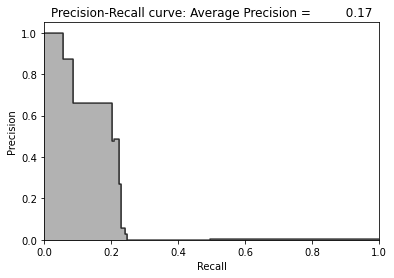

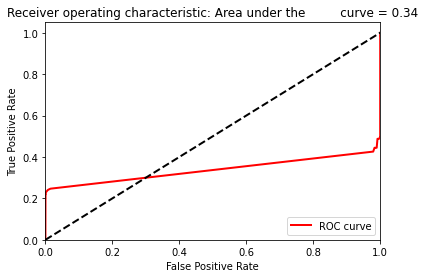

In [13]:
predictions = pd.Series(data=gbm.predict(X_test, \
                num_iteration=gbm.best_iteration), index=X_test.index)
preds, average_precision = plotResults(y_test, predictions, True)

In [22]:
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print("Precision at 75% recall", precision)

Precision at 75% recall 0.00033266799733865603


사기 거래의 75%를 탐지할 때의 정밀도는 단 0.03퍼에 불가

# 9.3 비지도 학습 

이제 비지도 학습을 사용해 사기 탐지 솔루션을 구축. 이번에는 사기 거래 수를 오버샘플링해 훈련셋을 조정. 오버 샘플링은 주어진 데이터셋의 클래스 분포를 조정하는 데 사용하는 기술. 우리가 훈련시키는 오토인코더가 정상/비사기 거래와 비정상/사기 거래를 더욱 쉽게 구분할 수 있도록 데이터셋에 사기성 거래를 더 많이 추가.

이전 작업에서 훈련셋에 존재하는 사기 거래를 90%를 삭제. 그결과 훈련셋에 남은 사기 거래 건수는 단 33건. 이 사기 거래 33건을 100배 복제한 다음 훈련 데이터셋에 추가. 또한 오버샘플링되지 않은 훈련셋의 복사본을 보관해 나머지 머신러닝 파이프 라인에서 사용.

테스트셋은 별도로 건들지 않고 오버샘플링은 훈련셋에서만 적용.

In [23]:
oversample_multiplier = 100

X_train_original = X_train.copy()
y_train_original = y_train.copy()
X_test_original = X_test.copy()
y_test_original = y_test.copy()

X_train_oversampled = X_train.copy()
y_train_oversampled = y_train.copy()
X_train_oversampled = X_train_oversampled.append( \
        [X_train_oversampled[y_train==1]]*oversample_multiplier, \
        ignore_index=False)
y_train_oversampled = y_train_oversampled.append( \
        [y_train_oversampled[y_train==1]]*oversample_multiplier, \
        ignore_index=False)

X_train = X_train_oversampled.copy()
y_train = y_train_oversampled.copy()

In [24]:
model = Sequential()
model.add(Dense(units=40, activation='linear', \
                activity_regularizer=regularizers.l1(10e-5), \
                input_dim=29,name='hidden_layer'))
model.add(Dropout(0.02))
model.add(Dense(units=29, activation='linear'))

In [25]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [26]:
num_epochs = 5
batch_size = 32

history = model.fit(x=X_train, y=X_train,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.20,
                    verbose=1)

Train on 155058 samples, validate on 38765 samples
Epoch 1/5
155058/155058 [==============================] - 9s 61us/sample - loss: 0.0833 - accuracy: 0.8628 - val_loss: 0.0394 - val_accuracy: 0.9824
Epoch 2/5
155058/155058 [==============================] - 10s 61us/sample - loss: 0.0185 - accuracy: 0.9268 - val_loss: 0.0067 - val_accuracy: 0.9832
Epoch 3/5
155058/155058 [==============================] - 9s 58us/sample - loss: 0.0175 - accuracy: 0.9278 - val_loss: 0.0608 - val_accuracy: 0.9778
Epoch 4/5
155058/155058 [==============================] - 9s 60us/sample - loss: 0.0178 - accuracy: 0.9274 - val_loss: 0.0126 - val_accuracy: 0.9691
Epoch 5/5
155058/155058 [==============================] - 9s 57us/sample - loss: 0.0176 - accuracy: 0.9275 - val_loss: 0.0535 - val_accuracy: 0.9760


190523/190523 [==============================] - 5s 24us/sample


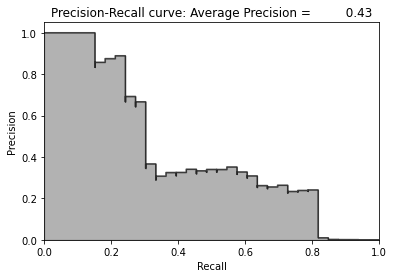

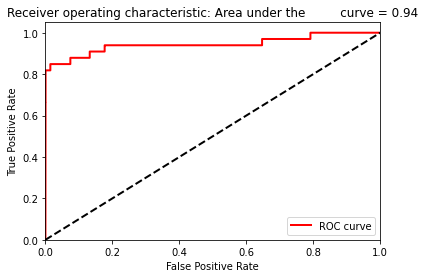

In [27]:
predictionsTrain = model.predict(X_train_original, verbose=1)
anomalyScoresAETrain = anomalyScores(X_train_original, predictionsTrain)
preds, average_precision = plotResults(y_train_original, \
                                      anomalyScoresAETrain, True)

93987/93987 [==============================] - 2s 24us/sample


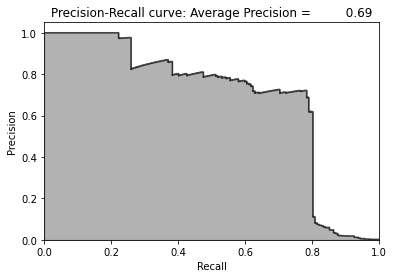

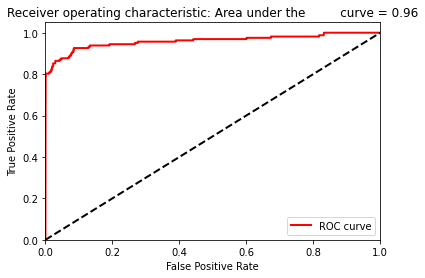

In [28]:
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds, average_precision = plotResults(y_test, anomalyScoresAE, True)

In [29]:
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print("Precision at 75% recall", precision)

Precision at 75% recall 0.7192982456140351


정밀도-재현율 곡선에 기초한 테스트셋의 평균 정밀도는 0.69이다. 사기 거래의 75%를 탐지할 때 정밀도는 71.9%. 비지도 학습 솔루션의 평균 정밀도는 지도 학습 솔루션보다 더 뛰어나고 75% 재현율에서도 비지도학습이 71.9%로 더 좋다.

# 9.4 준지도 학습 모델

이제 오토인코더(은닉층)가 학습한 표현을 원본 훈련셋과 결합해 그레디언트 부스팅 알고리즘에 사용. 이는 지도 학습의 장점과 비지도 학습의 장점을 혼합해서 사용하는 준지도 학습 방식.


In [ ]:
layer_name = 'hidden_layer'

intermediate_layer_model = Model(inputs = model.input, outputs = model.get_layer(layer_name).output)
intermediate_output_train = intermediate_layer_model.predict(X_train_original)
intermediate_output_test =intermediate_layer_model.predict(X_test_original)

이 오토인코더 표현을 데이터 프레임에 저장한 다음 원본 훈련셋과 결합. 

In [30]:
intermediate_output_trainDF = pd.DataFrame(data= intermediate_output_train, index= X_train_original.index)
intermediate_output_testDF = pd.DataFrame(data= intermediate_output_test ,index =X_test_original.index)

X_train = X_train_original.merge(intermediate_output_trainDF , left_index = True, right_index = True)
X_test =X_test_original.merge(intermediate_output_testDF, left_index= True ,right_index =True)

y_train = y_train_original.copy()

In [31]:
intermediate_output_testDF

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
67353,0.129827,0.080304,0.376744,-0.068210,0.753238,0.099443,-0.443871,0.148377,0.305429,-0.217591,...,-0.762040,-0.038919,-0.509483,-0.137286,-0.159423,0.718186,-0.075070,-0.220039,0.562713,0.218011
67626,0.844132,0.400854,-0.186615,0.263526,-0.505062,-1.254237,-0.334915,1.543931,-0.201517,-0.210628,...,-0.011367,0.325969,-0.053714,-0.489599,0.605276,-0.601172,0.072968,0.399891,-0.343333,-0.187129
169699,0.582085,-0.637079,1.517510,-0.216399,-0.327944,0.046855,-0.180088,-0.752199,-0.380897,-1.243498,...,0.276981,-0.229114,0.375308,0.288401,0.132751,-0.189642,0.026849,0.245951,0.781272,-0.995172
217315,-1.175211,-0.538262,0.677843,-0.357613,-1.219106,1.467985,1.124411,1.779166,-0.444294,1.700023,...,-0.556687,-0.060396,-0.778311,1.233504,0.393655,-0.418269,-0.703737,-0.197557,0.002029,-0.658623
111420,-0.277221,-0.691326,-1.136330,0.253044,-0.185462,0.686606,0.517635,0.318437,0.913567,-0.786735,...,-0.732886,-0.170489,-0.043382,-0.194141,-0.346945,-0.543366,0.178670,1.009534,0.022245,0.414161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70762,-0.319958,0.152759,-0.684912,0.531620,0.401423,-0.007140,0.505526,-0.254189,0.304746,0.088292,...,-0.109467,-0.350719,0.570046,-0.176227,-0.076870,0.343572,-0.219318,0.195139,-0.024450,0.297589
69843,-2.765383,1.926241,2.916605,-2.470292,-6.647522,1.847176,0.017651,7.269486,-2.201132,5.896795,...,0.876925,0.253660,-3.576447,3.317840,1.187003,0.697449,-2.507924,-0.597409,1.333924,-0.197044
191806,1.252446,-0.861130,0.444679,-0.032657,0.334777,0.869986,-0.056560,-0.875548,1.134012,-0.120521,...,0.266140,-0.838662,-1.019596,0.449547,0.558700,-0.160155,-0.345981,0.642138,-0.133249,-0.065581
259722,0.245802,-0.864220,0.374296,0.099662,0.280318,0.638810,-0.072463,0.330904,-0.139782,0.468118,...,0.444159,0.353763,0.644291,0.534254,0.121553,-0.641929,-0.036452,-0.694149,-0.418302,-0.374484


In [33]:
intermediate_layer_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_input (InputLay [(None, 29)]              0         
_________________________________________________________________
hidden_layer (Dense)         (None, 40)                1200      
Total params: 1,200
Trainable params: 1,200
Non-trainable params: 0
_________________________________________________________________


In [34]:
X_train = X_train_original.merge(intermediate_output_trainDF, \
                                 left_index=True,right_index=True)
X_test = X_test_original.merge(intermediate_output_testDF, \
                               left_index=True,right_index=True)
y_train = y_train_original.copy()

X_train

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,30,31,32,33,34,35,36,37,38,39
142087,-1.011878,1.170867,0.201381,-0.252129,-0.386390,-0.049420,-0.192587,0.932578,-0.220587,0.378852,...,0.046700,-0.122143,-0.276365,-0.325037,-0.111990,0.197966,0.095805,0.002568,0.136778,0.374825
165168,0.072173,0.665164,-0.241837,-0.380205,0.699456,-0.634194,0.838470,-0.137344,-0.167262,-0.790319,...,0.734225,0.054895,0.439780,0.430959,0.267646,0.184882,0.890003,0.303186,0.239748,0.066731
235908,0.099579,-0.389819,-0.944884,-1.492064,-0.090536,-0.879539,1.260059,-0.577069,-2.758547,0.977409,...,-0.501708,0.741373,-0.750947,0.132148,0.363310,0.269731,0.528525,0.014658,0.338553,0.469586
148255,0.015623,0.520260,0.191791,-0.418058,0.320155,-0.775673,0.821509,-0.159150,-0.060892,-0.391007,...,0.171893,0.279246,0.584669,0.282260,-0.266772,0.149584,0.337888,0.425140,0.043263,0.070803
145672,0.009169,0.524802,0.173686,-0.334556,0.766454,0.505087,0.267757,0.189101,-0.186534,-0.833822,...,0.331880,0.087693,0.593272,0.911242,0.220842,0.548067,0.615325,0.413010,-0.004447,0.020485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30023,-0.249496,0.101075,0.909879,-0.688839,-0.389697,-0.969098,0.404471,-0.295909,-1.322352,0.191754,...,0.004077,0.323563,-0.205979,0.202164,-0.888666,-0.629522,0.493764,0.013830,0.664657,0.027679
195475,-0.254091,-2.756705,-2.082848,0.720192,-0.770847,0.043816,1.347183,-0.309383,0.281819,-0.211026,...,-0.735786,0.524894,-1.207761,1.033057,1.010733,0.363415,-1.161829,0.170695,0.467451,0.125956
48687,0.106034,-1.131050,-0.470366,0.156445,-0.553642,-0.376423,0.654146,-0.283678,0.204805,-0.432029,...,0.073144,0.697002,0.008812,0.136485,0.161407,-0.102030,-0.679957,0.143483,0.579746,0.093779
159608,0.055698,0.496830,-0.098914,-0.582971,0.647489,-0.393782,0.810516,-0.116346,0.031466,-0.378264,...,-0.011700,0.400450,0.444630,0.160705,-0.441737,0.146194,0.112992,0.616306,0.227605,-0.353866


In [35]:
X_train_original

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
142087,-1.011878,1.170867,0.201381,-0.252129,-0.386390,-0.049420,-0.192587,0.932578,-0.220587,0.378852,...,0.238737,-0.233631,-0.783226,0.157078,-0.586703,-0.161425,0.230941,0.525280,0.473651,-0.297296
165168,0.072173,0.665164,-0.241837,-0.380205,0.699456,-0.634194,0.838470,-0.137344,-0.167262,-0.790319,...,0.098082,-0.446548,-1.039925,0.148460,1.079003,-0.761713,0.220597,0.564453,0.262996,-0.337757
235908,0.099579,-0.389819,-0.944884,-1.492064,-0.090536,-0.879539,1.260059,-0.577069,-2.758547,0.977409,...,0.135386,0.615087,2.051663,0.537784,1.887247,-0.950002,0.194730,0.394588,0.814038,0.499962
148255,0.015623,0.520260,0.191791,-0.418058,0.320155,-0.775673,0.821509,-0.159150,-0.060892,-0.391007,...,-0.039324,-0.342336,-0.740217,0.130539,-0.027853,-0.956686,0.296304,0.619910,0.294929,-0.329281
145672,0.009169,0.524802,0.173686,-0.334556,0.766454,0.505087,0.267757,0.189101,-0.186534,-0.833822,...,0.107825,-0.201647,-0.456069,0.049791,-0.727602,-2.183860,-0.148240,0.585847,0.762249,-0.333279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30023,-0.249496,0.101075,0.909879,-0.688839,-0.389697,-0.969098,0.404471,-0.295909,-1.322352,0.191754,...,0.115211,0.369245,1.209182,-0.066533,1.627214,0.628748,-0.301789,-0.110189,0.057551,-0.241283
195475,-0.254091,-2.756705,-2.082848,0.720192,-0.770847,0.043816,1.347183,-0.309383,0.281819,-0.211026,...,3.172416,1.379262,-0.221650,-1.822138,0.611275,-0.865244,1.296414,-0.902976,0.455664,5.005845
48687,0.106034,-1.131050,-0.470366,0.156445,-0.553642,-0.376423,0.654146,-0.283678,0.204805,-0.432029,...,1.498658,0.098597,-1.586216,-0.825029,-0.620769,0.109427,1.733472,-0.501687,0.300189,2.041624
159608,0.055698,0.496830,-0.098914,-0.582971,0.647489,-0.393782,0.810516,-0.116346,0.031466,-0.378264,...,0.002229,-0.444765,-1.058758,-0.074376,-1.672445,-0.672678,0.420560,0.603711,0.263881,-0.320925


이제 이 새로운 훈련셋의 69개 피처( 원본 데이터셋에 있는 29개 피처 및 오토인코더 표현의 새로 생성된 40개 피처)로 모델을 훈련.

In [36]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index, \
                                        columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), \
                                          y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
        X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=5000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, 
                                gbm.predict(X_train_fold, \
                                num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = \
        gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, \
            predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLightGBMGradientBoosting = log_loss(y_train, \
                        predictionsBasedOnKFolds.loc[:,'prediction'])
print('LightGBM Gradient Boosting Log Loss: ', \
                        loglossLightGBMGradientBoosting)

[1]	valid_0's binary_logloss: 0.00234525
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.00219996
[3]	valid_0's binary_logloss: 0.00214744
[4]	valid_0's binary_logloss: 0.00210115
[5]	valid_0's binary_logloss: 0.00206778
[6]	valid_0's binary_logloss: 0.00203672
[7]	valid_0's binary_logloss: 0.002187
[8]	valid_0's binary_logloss: 0.00216921
[9]	valid_0's binary_logloss: 0.0020861
[10]	valid_0's binary_logloss: 0.00207491
[11]	valid_0's binary_logloss: 0.00206576
[12]	valid_0's binary_logloss: 0.002055
[13]	valid_0's binary_logloss: 0.00204739
[14]	valid_0's binary_logloss: 0.00204164
[15]	valid_0's binary_logloss: 0.00203396
[16]	valid_0's binary_logloss: 0.00202895
[17]	valid_0's binary_logloss: 0.00202347
[18]	valid_0's binary_logloss: 0.00201693
[19]	valid_0's binary_logloss: 0.00201097
[20]	valid_0's binary_logloss: 0.00200663
[21]	valid_0's binary_logloss: 0.00200137
[22]	valid_0's binary_logloss: 0.00199757
[23]	valid_0's binary_loglos

[195]	valid_0's binary_logloss: 0.00184449
[196]	valid_0's binary_logloss: 0.00184488
[197]	valid_0's binary_logloss: 0.00184528
[198]	valid_0's binary_logloss: 0.00184568
[199]	valid_0's binary_logloss: 0.00184612
[200]	valid_0's binary_logloss: 0.00184653
[201]	valid_0's binary_logloss: 0.00184695
[202]	valid_0's binary_logloss: 0.00184736
[203]	valid_0's binary_logloss: 0.00184778
[204]	valid_0's binary_logloss: 0.00184821
[205]	valid_0's binary_logloss: 0.00184863
[206]	valid_0's binary_logloss: 0.00184907
[207]	valid_0's binary_logloss: 0.0018495
[208]	valid_0's binary_logloss: 0.00184994
[209]	valid_0's binary_logloss: 0.00185038
[210]	valid_0's binary_logloss: 0.00185082
[211]	valid_0's binary_logloss: 0.00185127
[212]	valid_0's binary_logloss: 0.00185172
[213]	valid_0's binary_logloss: 0.00185218
[214]	valid_0's binary_logloss: 0.00185264
[215]	valid_0's binary_logloss: 0.0018531
[216]	valid_0's binary_logloss: 0.00185356
[217]	valid_0's binary_logloss: 0.00185403
[218]	valid_0

[48]	valid_0's binary_logloss: 0.00371034
[49]	valid_0's binary_logloss: 0.00370409
[50]	valid_0's binary_logloss: 0.00369752
[51]	valid_0's binary_logloss: 0.00369112
[52]	valid_0's binary_logloss: 0.00368477
[53]	valid_0's binary_logloss: 0.00367835
[54]	valid_0's binary_logloss: 0.00367152
[55]	valid_0's binary_logloss: 0.00366584
[56]	valid_0's binary_logloss: 0.00366014
[57]	valid_0's binary_logloss: 0.00365446
[58]	valid_0's binary_logloss: 0.0036487
[59]	valid_0's binary_logloss: 0.00364286
[60]	valid_0's binary_logloss: 0.00363706
[61]	valid_0's binary_logloss: 0.00363095
[62]	valid_0's binary_logloss: 0.00362181
[63]	valid_0's binary_logloss: 0.00360519
[64]	valid_0's binary_logloss: 0.00359748
[65]	valid_0's binary_logloss: 0.00358421
[66]	valid_0's binary_logloss: 0.00357685
[67]	valid_0's binary_logloss: 0.00356537
[68]	valid_0's binary_logloss: 0.00355834
[69]	valid_0's binary_logloss: 0.00355144
[70]	valid_0's binary_logloss: 0.00354374
[71]	valid_0's binary_logloss: 0.00

[33]	valid_0's binary_logloss: 0.00475878
[34]	valid_0's binary_logloss: 0.00475659
[35]	valid_0's binary_logloss: 0.00475339
[36]	valid_0's binary_logloss: 0.0047513
[37]	valid_0's binary_logloss: 0.00474926
[38]	valid_0's binary_logloss: 0.00474727
[39]	valid_0's binary_logloss: 0.00474429
[40]	valid_0's binary_logloss: 0.00474239
[41]	valid_0's binary_logloss: 0.00474054
[42]	valid_0's binary_logloss: 0.00473872
[43]	valid_0's binary_logloss: 0.00473596
[44]	valid_0's binary_logloss: 0.00473422
[45]	valid_0's binary_logloss: 0.0047326
[46]	valid_0's binary_logloss: 0.00473004
[47]	valid_0's binary_logloss: 0.00472846
[48]	valid_0's binary_logloss: 0.00472692
[49]	valid_0's binary_logloss: 0.00472443
[50]	valid_0's binary_logloss: 0.00472302
[51]	valid_0's binary_logloss: 0.00472157
[52]	valid_0's binary_logloss: 0.00472015
[53]	valid_0's binary_logloss: 0.00471788
[54]	valid_0's binary_logloss: 0.00471647
[55]	valid_0's binary_logloss: 0.00471514
[56]	valid_0's binary_logloss: 0.004

[22]	valid_0's binary_logloss: 0.00346869
[23]	valid_0's binary_logloss: 0.00346667
[24]	valid_0's binary_logloss: 0.00346463
[25]	valid_0's binary_logloss: 0.00346279
[26]	valid_0's binary_logloss: 0.00346092
[27]	valid_0's binary_logloss: 0.0034577
[28]	valid_0's binary_logloss: 0.00345814
[29]	valid_0's binary_logloss: 0.00345497
[30]	valid_0's binary_logloss: 0.0034519
[31]	valid_0's binary_logloss: 0.00345153
[32]	valid_0's binary_logloss: 0.00344849
[33]	valid_0's binary_logloss: 0.00344497
[34]	valid_0's binary_logloss: 0.00344391
[35]	valid_0's binary_logloss: 0.00344049
[36]	valid_0's binary_logloss: 0.00327322
[37]	valid_0's binary_logloss: 0.00327005
[38]	valid_0's binary_logloss: 0.00326182
[39]	valid_0's binary_logloss: 0.00325999
[40]	valid_0's binary_logloss: 0.00325814
[41]	valid_0's binary_logloss: 0.00325496
[42]	valid_0's binary_logloss: 0.00325364
[43]	valid_0's binary_logloss: 0.00325061
[44]	valid_0's binary_logloss: 0.00324917
[45]	valid_0's binary_logloss: 0.003

[217]	valid_0's binary_logloss: 0.0030811
[218]	valid_0's binary_logloss: 0.00308132
[219]	valid_0's binary_logloss: 0.00308116
[220]	valid_0's binary_logloss: 0.00308022
[221]	valid_0's binary_logloss: 0.00308031
[222]	valid_0's binary_logloss: 0.00307959
[223]	valid_0's binary_logloss: 0.00307962
[224]	valid_0's binary_logloss: 0.00307876
[225]	valid_0's binary_logloss: 0.00307789
[226]	valid_0's binary_logloss: 0.00307811
[227]	valid_0's binary_logloss: 0.00307815
[228]	valid_0's binary_logloss: 0.00307723
[229]	valid_0's binary_logloss: 0.00307732
[230]	valid_0's binary_logloss: 0.00307679
[231]	valid_0's binary_logloss: 0.00307595
[232]	valid_0's binary_logloss: 0.00307447
[233]	valid_0's binary_logloss: 0.00307368
[234]	valid_0's binary_logloss: 0.00307391
[235]	valid_0's binary_logloss: 0.00307401
[236]	valid_0's binary_logloss: 0.00307312
[237]	valid_0's binary_logloss: 0.00307298
[238]	valid_0's binary_logloss: 0.00307152
[239]	valid_0's binary_logloss: 0.00307174
[240]	valid_

[413]	valid_0's binary_logloss: 0.00294844
[414]	valid_0's binary_logloss: 0.00294784
[415]	valid_0's binary_logloss: 0.00294651
[416]	valid_0's binary_logloss: 0.0029464
[417]	valid_0's binary_logloss: 0.00294508
[418]	valid_0's binary_logloss: 0.00294509
[419]	valid_0's binary_logloss: 0.00294499
[420]	valid_0's binary_logloss: 0.00294367
[421]	valid_0's binary_logloss: 0.00294317
[422]	valid_0's binary_logloss: 0.00294307
[423]	valid_0's binary_logloss: 0.00294175
[424]	valid_0's binary_logloss: 0.00294245
[425]	valid_0's binary_logloss: 0.00294253
[426]	valid_0's binary_logloss: 0.00294122
[427]	valid_0's binary_logloss: 0.00294112
[428]	valid_0's binary_logloss: 0.00294117
[429]	valid_0's binary_logloss: 0.00294188
[430]	valid_0's binary_logloss: 0.00294058
[431]	valid_0's binary_logloss: 0.0029402
[432]	valid_0's binary_logloss: 0.00294027
[433]	valid_0's binary_logloss: 0.00293953
[434]	valid_0's binary_logloss: 0.00294023
[435]	valid_0's binary_logloss: 0.00293894
[436]	valid_0

[609]	valid_0's binary_logloss: 0.00295004
[610]	valid_0's binary_logloss: 0.00294972
[611]	valid_0's binary_logloss: 0.00295041
[612]	valid_0's binary_logloss: 0.00295038
[613]	valid_0's binary_logloss: 0.00295007
[614]	valid_0's binary_logloss: 0.00294975
[615]	valid_0's binary_logloss: 0.00295044
[616]	valid_0's binary_logloss: 0.00295014
[617]	valid_0's binary_logloss: 0.00295083
[618]	valid_0's binary_logloss: 0.0029505
[619]	valid_0's binary_logloss: 0.0029512
[620]	valid_0's binary_logloss: 0.00295089
[621]	valid_0's binary_logloss: 0.00295158
[622]	valid_0's binary_logloss: 0.00295112
[623]	valid_0's binary_logloss: 0.00295079
[624]	valid_0's binary_logloss: 0.00295071
[625]	valid_0's binary_logloss: 0.0029504
[626]	valid_0's binary_logloss: 0.00295109
[627]	valid_0's binary_logloss: 0.00294985
[628]	valid_0's binary_logloss: 0.00294952
[629]	valid_0's binary_logloss: 0.00295021
[630]	valid_0's binary_logloss: 0.0029499
[631]	valid_0's binary_logloss: 0.00294922
[632]	valid_0's

[146]	valid_0's binary_logloss: 0.000708368
[147]	valid_0's binary_logloss: 0.00070891
[148]	valid_0's binary_logloss: 0.000708765
[149]	valid_0's binary_logloss: 0.000709322
[150]	valid_0's binary_logloss: 0.000709893
[151]	valid_0's binary_logloss: 0.000710473
[152]	valid_0's binary_logloss: 0.000710392
[153]	valid_0's binary_logloss: 0.000710299
[154]	valid_0's binary_logloss: 0.000710894
[155]	valid_0's binary_logloss: 0.000711496
[156]	valid_0's binary_logloss: 0.000711426
[157]	valid_0's binary_logloss: 0.000712048
[158]	valid_0's binary_logloss: 0.000712672
[159]	valid_0's binary_logloss: 0.00071263
[160]	valid_0's binary_logloss: 0.000713267
[161]	valid_0's binary_logloss: 0.00071391
[162]	valid_0's binary_logloss: 0.000714564
[163]	valid_0's binary_logloss: 0.000714558
[164]	valid_0's binary_logloss: 0.00071456
[165]	valid_0's binary_logloss: 0.000714596
[166]	valid_0's binary_logloss: 0.000715275
[167]	valid_0's binary_logloss: 0.000715302
[168]	valid_0's binary_logloss: 0.00

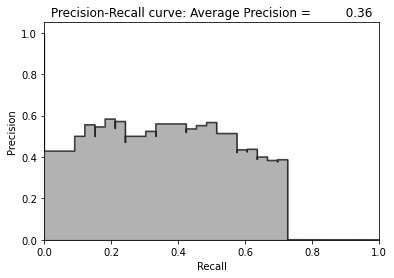

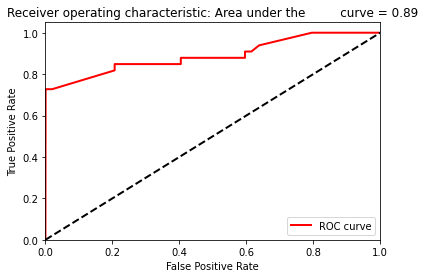

In [37]:
preds, average_precision = plotResults(y_train, \
                        predictionsBasedOnKFolds.loc[:,'prediction'], True)

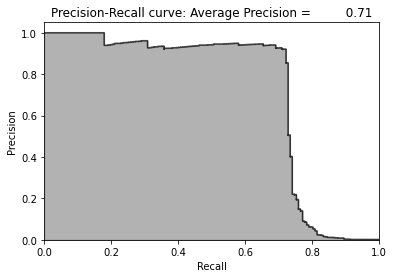

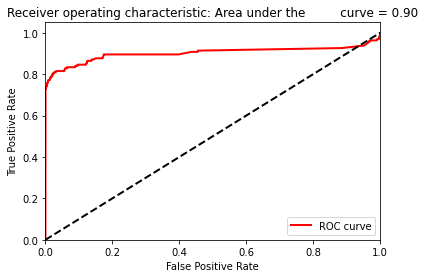

In [38]:
predictions = pd.Series(data=gbm.predict(X_test, \
                    num_iteration=gbm.best_iteration),index=X_test.index)
preds, average_precision = plotResults(y_test, predictions, True)

In [39]:
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print(precision)

0.1949286846275753


# 9.5 지도 학습과 비지도 학습의 강력함

이 준지도 학습 신용카드 사기 탐지 솔루션에서 지도 학습과 비지도 학습은 모두 중요한 역할을 수행한다. 이를 확인하는 한 가지 방법은 최종 그래디언트 부스팅 모델에서 가장 중요하다고 식별한 피처들을 분석하는 것이다. 바로 직전에 훈련시킨 모델의 피처 중요도 값을 확인.

In [40]:
featuresImportance = pd.DataFrame(data=list(gbm.feature_importance()), \
                        index=X_train.columns,columns=['featImportance'])
featuresImportance = featuresImportance/featuresImportance.sum()
featuresImportance.sort_values(by='featImportance', \
                               ascending=False,inplace=True)
featuresImportance

,featImportance
31,0.083282
Amount,0.057989
V13,0.056755
3,0.045651
V25,0.043800
...,...
V28,0.000000
V27,0.000000
V20,0.000000
24,0.000000


여기에서 볼 수 잇듯이 주요 피처 중 일부는 오토인코더에 의해 학습된 은닉층의 피처(이름 앞에 'V'가 없는 피처)이며, 그 외에는 Amount(거래량 피처)와 원본 데이터셋의 주성분(이름 앞에 'V'가 있는 피처)이다.

# 9.6 마치며 

준지도 학습 모델은 독립형 지도 학습 모델과 독립형 비지도 학습 모델의 성능을 모두 능가한다. 

이 장에서는 준지도 학습으로 가능한 것 중 일부만 다루었지만 이를 계기로 지도 학습과 비지도 학습 간 비교나 최적의 응용 솔루션을 찾기 윟 ㅐ지도 학습과 비지도 학습을 결합하는 방법에 대한 아이디어를 재구성하는데 도움이 될 것.

In [42]:
pd.DataFrame(data=list(gbm.feature_importance()), \
                        index=X_train.columns,columns=['featImportance'])

,featImportance
V1,33
V2,4
V3,36
V4,2
V5,24
...,...
35,15
36,11
37,1
38,49


In [44]:
gbm.feature_importance()

array([ 33,   4,  36,   2,  24,  46,  50,  23,   9,  31,  11,   7,  92,
         1,   4,  42,  15,  47,  15,   0,  66,  10,  47,   7,  71,  59,
         0,   0,  94,  24,   1,  15,  74,  25,   0,   3,   6,   3,  21,
         1,   1,  31,  34,  18,   3,   4,  21,  29,  21,   0,  53,   2,
        23,   0,  23,  10,   2,   6,   1,   4, 135,  22,   1,  25,  15,
        11,   1,  49,  57])